In [1]:
pip install ffmpeg-python


In [3]:
import ffmpeg

def get_video_info(video_path):
    probe = ffmpeg.probe(video_path)
    video_info = next(stream for stream in probe['streams'] if stream['codec_type'] == 'video')

    frame_rate = eval(video_info['r_frame_rate'])  # Evaluates the frame rate string (e.g., "30/1")
    frame_count = int(video_info.get('nb_frames', 0))  # Use .get() to avoid KeyError
    duration = float(video_info['duration'])

    return {
        'frame_rate': frame_rate,
        'frame_count': frame_count,
        'duration': duration
    }

video_path = "/content/sample.mp4"

info = get_video_info(video_path)
print(f"Frame Rate: {info['frame_rate']} fps")
print(f"Frame Count: {info['frame_count']} frames")
print(f"Duration: {info['duration']} seconds")


Frame Rate: 30.0 fps
Frame Count: 0 frames
Duration: 163.1 seconds


FFmpeg error: ffprobe version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2007-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enabl

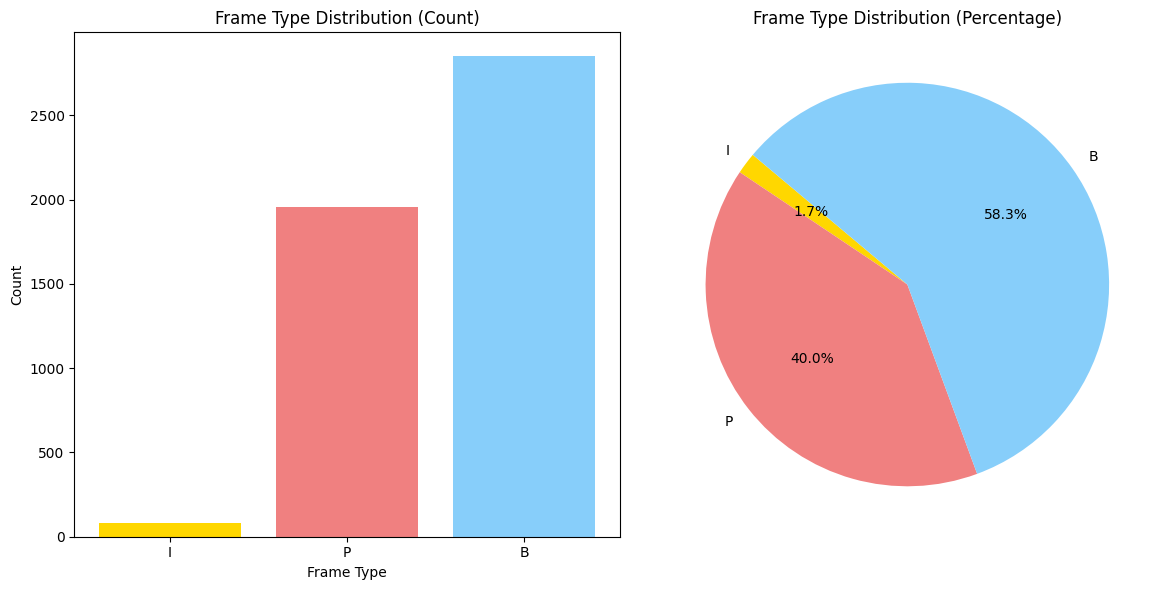

In [8]:
import ffmpeg
import matplotlib.pyplot as plt
import subprocess
import json

def get_video_info(video_path):
    probe = ffmpeg.probe(video_path)
    video_info = next(stream for stream in probe['streams'] if stream['codec_type'] == 'video')

    frame_rate = eval(video_info['r_frame_rate'])
    frame_count = int(video_info.get('nb_frames', 0))
    duration = float(video_info['duration'])

    return {
        'frame_rate': frame_rate,
        'frame_count': frame_count,
        'duration': duration
    }

def count_frame_types(video_path):
    frame_types = {'I': 0, 'P': 0, 'B': 0}
    try:
        result = ffmpeg.probe(video_path, select_streams='v', show_frames=True, show_entries='frame=pict_type')
        for frame in result['frames']:
            if 'pict_type' in frame:
                frame_types[frame['pict_type']] += 1
    except ffmpeg.Error as e:
        print(f"FFmpeg error: {e.stderr.decode()}")
    return frame_types

def count_frame_types_alternative(video_path):
    frame_types = {'I': 0, 'P': 0, 'B': 0}
    command = [
        'ffprobe',
        '-v', 'error',
        '-select_streams', 'v:0',
        '-show_entries', 'frame=pict_type',
        '-of', 'json',
        video_path
    ]
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output = json.loads(result.stdout)
        for frame in output['frames']:
            if 'pict_type' in frame:
                frame_types[frame['pict_type']] += 1
    except Exception as e:
        print(f"Error: {e}")
    return frame_types

def calculate_frame_percentages(frame_types):
    total_frames = sum(frame_types.values())
    percentages = {frame_type: (count / total_frames) * 100 for frame_type, count in frame_types.items()}
    return percentages

def plot_frame_distribution(frame_types, percentages):
    labels = frame_types.keys()
    counts = frame_types.values()
    colors = ['gold', 'lightcoral', 'lightskyblue']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(labels, counts, color=colors)
    plt.xlabel('Frame Type')
    plt.ylabel('Count')
    plt.title('Frame Type Distribution (Count)')

    plt.subplot(1, 2, 2)
    plt.pie(percentages.values(), labels=percentages.keys(), colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Frame Type Distribution (Percentage)')

    plt.tight_layout()
    plt.show()


%matplotlib inline

video_path = "/content/sample.mp4"

frame_types = count_frame_types(video_path)
if not frame_types.get('I') and not frame_types.get('P') and not frame_types.get('B'):
    frame_types = count_frame_types_alternative(video_path)
print(f"Frame Types: {frame_types}")

percentages = calculate_frame_percentages(frame_types)
print(f"Frame Type Percentages: {percentages}")

plot_frame_distribution(frame_types, percentages)


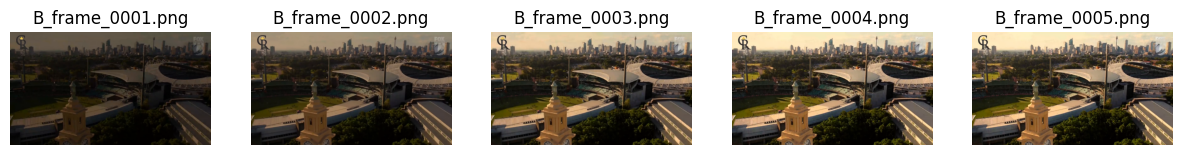

In [10]:
import cv2
from matplotlib import pyplot as plt

def display_frames_opencv(frame_dir):
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.png')])
    if not frame_files:
        print("No frames found.")
        return

    plt.figure(figsize=(15, 5))
    for i, frame_file in enumerate(frame_files[:5]):  # Display the first 5 frames
        img = cv2.imread(os.path.join(frame_dir, frame_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(frame_file)

    plt.show()

# Display frames
display_frames_opencv(output_dir)


In [12]:
import os

def calculate_frame_sizes(frame_dir):
    frame_types = ['I', 'P', 'B']
    frame_sizes = {ft: [] for ft in frame_types}

    for frame_type in frame_types:
        for file_name in os.listdir(frame_dir):
            if file_name.startswith(frame_type) and file_name.endswith('.png'):
                file_path = os.path.join(frame_dir, file_name)
                file_size = os.path.getsize(file_path)
                frame_sizes[frame_type].append(file_size)

    average_sizes = {ft: sum(sizes) / len(sizes) if sizes else 0 for ft, sizes in frame_sizes.items()}
    return frame_sizes, average_sizes

# Calculate frame sizes
frame_sizes, average_sizes = calculate_frame_sizes(output_dir)

# Display average sizes
print("Average Frame Sizes (in bytes):")
for frame_type, avg_size in average_sizes.items():
    print(f"{frame_type} Frames: {avg_size:.2f} bytes")


Average Frame Sizes (in bytes):
I Frames: 873649.70 bytes
P Frames: 996340.26 bytes
B Frames: 1140148.72 bytes


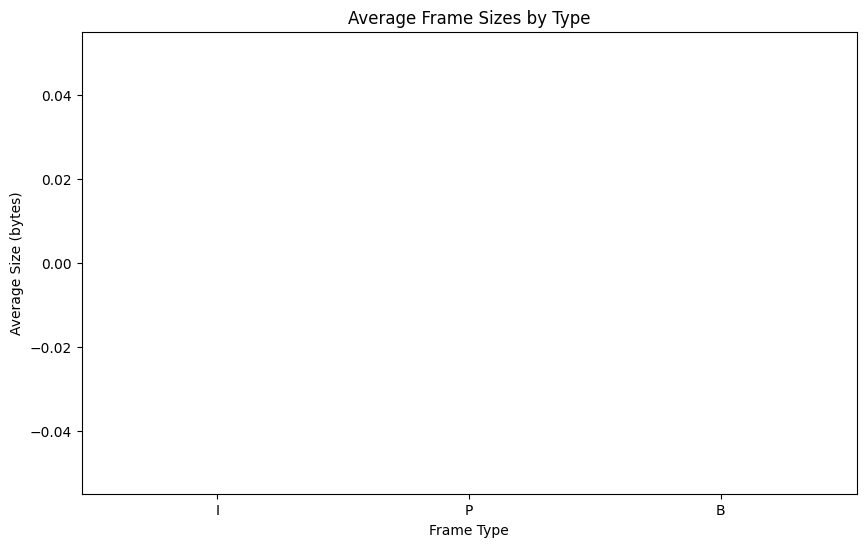

In [15]:
import matplotlib.pyplot as plt

def plot_frame_sizes(average_sizes):
    """Plots a bar chart of the average frame sizes."""
    frame_types = list(average_sizes.keys())
    sizes = list(average_sizes.values())

    plt.figure(figsize=(10, 6))
    plt.bar(frame_types, sizes, color=['blue', 'green', 'red'])
    plt.xlabel('Frame Type')
    plt.ylabel('Average Size (bytes)')
    plt.title('Average Frame Sizes by Type')
    plt.show()


plot_frame_sizes(average_sizes)


In [16]:
import subprocess
import os

def extract_i_frames(video_path, output_dir):
    """Extracts I frames from a video and saves them as images."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    command = [
        'ffmpeg',
        '-i', video_path,
        '-vf', 'select=eq(pict_type\,I)',
        '-vsync', 'vfr',
        f'{output_dir}/i_frame_%04d.png'
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Path to your video file and output directory
video_path = 'path/to/your/video.mp4'  # Change this to your video file path
output_dir = 'path/to/output/i_frames'  # Change this to your desired output directory

# Extract I frames
extract_i_frames(video_path, output_dir)


In [18]:
def reconstruct_video_from_i_frames(i_frames_dir, output_video_path, frame_rate=1):
    """Reconstructs a video using only I frames with a specified frame rate."""
    command = [
        'ffmpeg',
        '-framerate', str(frame_rate),  # Frame rate for the new video
        '-i', f'{i_frames_dir}/i_frame_%04d.png',
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        output_video_path
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Path to the directory with I frames and the output video path
i_frames_dir = '/content/path/to/output/i_frames'  # Change this to your I frames directory
output_video_path = '/content/reconstructed_video.mp4'  # Change this to your desired output video path

# Reconstruct the video
reconstruct_video_from_i_frames(i_frames_dir, output_video_path, frame_rate=1)
